<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [5]</a>'.</span>

# Simulating an All-Pass Filter
> A simple comparison between an analytical evaluation of an all pass filter and using SAX.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import sax

## Schematic
```svgbob
       in0 ============ out0
        ^                 ^
        |                 |
        v                 v
       in1              out1
         *               *
          \             /
           '-----------'
           .-----------.
          /             \
         *               *
in0 <- in0               out0 -> out0
```

## Simulation & Design Parameters

In [2]:
loss = 0.1  # [dB/μm] (alpha) waveguide loss
neff = 2.34  # Effective index of the waveguides
ng = 3.4  # Group index of the waveguides
wl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
ring_length = 10.0  # [μm] Length of the ring
coupling = 0.5  # [] coupling of the coupler
wl = jnp.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over

## Frequency Domain Analytically

As a comparison, we first calculate the frequency domain response for the all-pass filter analytically:

$$
o = \frac{t-10^{-\alpha L/20}\exp(2\pi j n_{\rm eff}(\lambda) L / \lambda)}{1-t10^{-\alpha L/20}\exp(2\pi j n_{\rm eff}(\lambda) L / \lambda)}s
$$

In [3]:
def all_pass_analytical(wl=1.5):
    """Analytic Frequency Domain Response of an all pass filter"""
    detected = jnp.zeros_like(wl)
    transmission = 1 - coupling
    neff_wl = (
        neff + (wl0 - wl) * (ng - neff) / wl0
    )  # we expect a linear behavior with respect to wavelength
    out = jnp.sqrt(transmission) - 10 ** (-loss * ring_length / 20.0) * jnp.exp(
        2j * jnp.pi * neff_wl * ring_length / wl
    )
    out /= 1 - jnp.sqrt(transmission) * 10 ** (-loss * ring_length / 20.0) * jnp.exp(
        2j * jnp.pi * neff_wl * ring_length / wl
    )
    detected = abs(out) ** 2
    return detected

CPU times: user 1.27 s, sys: 35.6 ms, total: 1.31 s
Wall time: 1.44 s
CPU times: user 181 ms, sys: 980 μs, total: 182 ms
Wall time: 145 ms
CPU times: user 146 μs, sys: 0 ns, total: 146 μs
Wall time: 152 μs


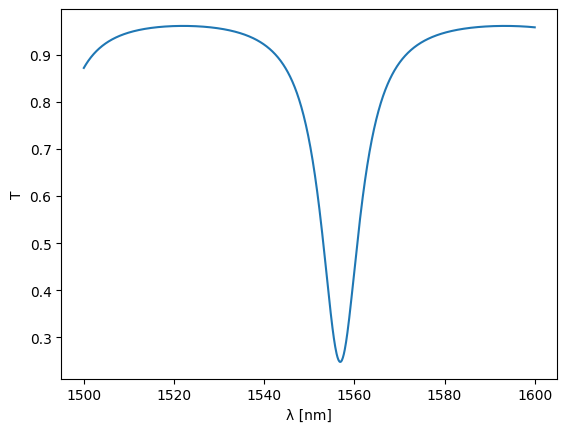

In [4]:
%time detected = all_pass_analytical(wl=wl) # non-jitted evaluation time
all_pass_analytical_jitted = jax.jit(all_pass_analytical)
%time detected = all_pass_analytical_jitted(wl=wl) # time to jit
%time detected = all_pass_analytical_jitted(wl=wl) # evaluation time after jitting

plt.plot(wl * 1e3, detected)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

## Scatter Dictionaries

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [5]:
_all_pass_sax, _ = sax.circuit(
    netlist={
        "instances": {
            "dc": {"component": "coupler", "settings": {"coupling": coupling}},
            "top": {
                "component": "straight",
                "settings": {
                    "length": ring_length,
                    "loss_dB_cm": loss * 1e4,
                    "neff": neff,
                    "ng": ng,
                    "wl0": wl0,
                    "wl": wl,
                },
            },
        },
        "connections": {
            "dc,out1": "top,in0",
            "top,out0": "dc,in1",
        },
        "ports": {
            "in0": "dc,in0",
            "out0": "dc,out0",
        },
    },
    models={
        "coupler": sax.models.coupler_ideal,
        "straight": sax.models.straight,
    },
)


def all_pass_sax(wl=1.5):
    sdict = sax.sdict(_all_pass_sax(wl=wl))
    return abs(sdict["in0", "out0"]) ** 2

AttributeError: module 'klujax' has no attribute 'analyze'

In [ ]:
%time detected_sax = all_pass_sax(wl=wl) # non-jitted evaluation time
all_pass_sax_jitted = jax.jit(all_pass_sax)
%time detected_sax = all_pass_sax_jitted(wl=wl) # time to jit
%time detected_sax = all_pass_sax_jitted(wl=wl) # time after jitting

plt.plot(wl * 1e3, detected, label="analytical")
plt.plot(wl * 1e3, detected_sax, label="sax", ls="--", lw=3)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()